# NekRS-ML GNN Scaling on Polaris

In [1]:
# Set up notebook
import os
import pathlib
import glob
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

from datetime import datetime

font = {
        'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

import matplotlib.font_manager
# matplotlib.font_manager.fontManager.ttflist

In [2]:
class NekRSML_GNN:
    def __init__(self,path,gpu_list):
        self.base_path = path
        self.gpu_list = gpu_list
        self.n_gpu = len(gpu_list)
        self.train_fom = {
            'train_tot': np.zeros((self.n_gpu,)),
            'train_epoch': np.zeros((self.n_gpu,4)),
            'throughput_epoch': np.zeros((self.n_gpu,4)),
            'train_batch': np.zeros((self.n_gpu,4)),
            'throughput_batch': np.zeros((self.n_gpu,4)),
            'throughput_epoch_par': np.zeros((self.n_gpu,)),
            'throughput_batch_par': np.zeros((self.n_gpu,)),
            'forward_pass': np.zeros((self.n_gpu,4)),
            'loss': np.zeros((self.n_gpu,4)),
            'backward_pass': np.zeros((self.n_gpu,4)),
            'optimizer_step': np.zeros((self.n_gpu,4)),
            'data_offload': np.zeros((self.n_gpu,4)),
            'buffer_init': np.zeros((self.n_gpu,4)),
            'collectives': np.zeros((self.n_gpu,4))
        }
        self.counts = {
            'train_tot': np.zeros((self.n_gpu,)),
            'train_epoch': np.zeros((self.n_gpu,)),
            'throughput_epoch': np.zeros((self.n_gpu,)),
            'train_batch': np.zeros((self.n_gpu,)),
            'throughput_batch': np.zeros((self.n_gpu,)),
            'throughput_epoch_par': np.zeros((self.n_gpu,)),
            'throughput_batch_par': np.zeros((self.n_gpu,)),
            'forward_pass': np.zeros((self.n_gpu,)),
            'loss': np.zeros((self.n_gpu,)),
            'backward_pass': np.zeros((self.n_gpu,)),
            'optimizer_step': np.zeros((self.n_gpu,)),
            'data_offload': np.zeros((self.n_gpu,)),
            'buffer_init': np.zeros((self.n_gpu,)),
            'collectives': np.zeros((self.n_gpu,))
        }
        
    def get_value(self,string):
        if 'INFO' in string:
            string = string.split(" - ")[1]
        return float(string.split(":")[1].strip())
    
    def get_values(self,string):
        if 'INFO' in string:
            string = string.split(" - ")[1]
        vals = string.split(":")[1].split(",")
        arr = np.zeros((4,))
        for i in range(4):
            arr[i] = float(vals[i].split('=')[-1].strip())
        return arr
    
    def parse_files(self):
        for i in range(self.n_gpu):
            #path = self.base_path+f"/{self.gpu_list[i]}/gnn_scale*"
            path = self.base_path+f"/{self.gpu_list[i]}/gnn_s*"
            # Loop over runs found
            run_files = glob.glob(path)
            for run_file in run_files:
                print('Reading file: ', run_file)
                with open(run_file,'r') as fh:
                    for l in fh:
                        if "Total training time" in l and "::" not in l:
                            self.train_fom['train_tot'][i] += self.get_value(l)
                            self.counts['train_tot'][i] += 1
                            
                        if "Training epoch" in l:
                            self.train_fom['train_epoch'][i] += self.get_values(l)
                            self.counts['train_epoch'][i] += 1
                        if "Training throughput" in l:
                            self.train_fom['throughput_epoch'][i] += self.get_values(l)
                            self.counts['throughput_epoch'][i] += 1
                        if "Average parallel training throughout" in l:
                            self.train_fom['throughput_epoch_par'][i] += self.get_value(l)
                            self.counts['throughput_epoch_par'][i] += 1
                            
                        if "Training batch" in l and "throughput" not in l:
                            self.train_fom['train_batch'][i] += self.get_values(l)
                            self.counts['train_batch'][i] += 1
                        if "Training batch throughput" in l:
                            self.train_fom['throughput_batch'][i] += self.get_values(l)
                            self.counts['throughput_batch'][i] += 1
                        if "Average parallel training batch throughout" in l:
                            self.train_fom['throughput_batch_par'][i] += self.get_value(l)
                            self.counts['throughput_batch_par'][i] += 1
                            
                        if "forwardPass" in l:
                            self.train_fom['forward_pass'][i] += self.get_values(l)
                            self.counts['forward_pass'][i] += 1
                        if "loss [" in l:
                            self.train_fom['loss'][i] += self.get_values(l)
                            self.counts['loss'][i] += 1
                        if "backwardPass" in l:
                            self.train_fom['backward_pass'][i] += self.get_values(l)
                            self.counts['backward_pass'][i] += 1
                        if "optimizerStep" in l:
                            self.train_fom['optimizer_step'][i] += self.get_values(l)
                            self.counts['optimizer_step'][i] += 1
                        if "dataTransfer" in l:
                            self.train_fom['data_offload'][i] += self.get_values(l)
                            self.counts['data_offload'][i] += 1
                        if "bufferInit" in l:
                            self.train_fom['buffer_init'][i] += self.get_values(l)
                            self.counts['buffer_init'][i] += 1
                        if "collectives" in l:
                            self.train_fom['collectives'][i] += self.get_values(l)
                            self.counts['collectives'][i] += 1

        # Divide by the counts for each gpu number to get the average over runs
        for key in self.train_fom.keys():
            val = self.train_fom[key]
            if len(val.shape)==1:
                #self.train_fom[key] = np.divide(val, self.counts[key], where=self.counts[key]>0)
                np.divide(val, self.counts[key], out=self.train_fom[key], where=self.counts[key]>0)
            else:
                for j in range(val.shape[1]):
                    #self.train_fom[key][:,j] = np.divide(val[:,j], self.counts[key], where=self.counts[key]>0)
                    np.divide(val[:,j], self.counts[key], out=self.train_fom[key][:,j], where=self.counts[key]>0)

## Load All Data

In [3]:
top_dir = "/Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/"

In [4]:
#### Polaris, 500k, large
# NekRS-ML Model, no halo exchange
case_dir = "polaris/500k/large/none"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
polaris_5_l_no = NekRSML_GNN(dir_path,gpu_list)
polaris_5_l_no.parse_files()

# NekRS-ML Model, no halo exchange, no NCCL or FI flags
case_dir = "polaris/500k/large/none_noflags"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
polaris_5_l_no2 = NekRSML_GNN(dir_path,gpu_list)
polaris_5_l_no2.parse_files()

# NekRS-ML Model, all_to_all halo exchange
case_dir = "polaris/500k/large/all2all"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
polaris_5_l_a2a = NekRSML_GNN(dir_path,gpu_list)
polaris_5_l_a2a.parse_files()

# NekRS-ML Model, all_to_all_opt exchange
case_dir = "polaris/500k/large/all2all_opt"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
polaris_5_l_a2ao = NekRSML_GNN(dir_path,gpu_list)
polaris_5_l_a2ao.parse_files()




Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/large/none/1/gnn_scale.o2028293
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/large/none/1/gnn_scale.o2016243
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/large/none/2/gnn_scale.o2029277
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/large/none/2/gnn_scale.o2016243
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/large/none/4/gnn_scale.o2029277
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/large/none/4/gnn_scale.o2016243
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/large/none/4/gnn_scale.o2039030
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/large/none/8/gnn_scale.o2029283
Reading file:  /Users/rbalin/Documents/R

In [5]:
#### Polaris, 500k, small
# NekRS-ML Model, no halo exchange
case_dir = "polaris/500k/small/none"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
polaris_5_s_no = NekRSML_GNN(dir_path,gpu_list)
polaris_5_s_no.parse_files()

# NekRS-ML Model, all_to_all halo exchange
case_dir = "polaris/500k/small/all2all"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
polaris_5_s_a2a = NekRSML_GNN(dir_path,gpu_list)
polaris_5_s_a2a.parse_files()

# NekRS-ML Model, all_to_all_opt exchange
case_dir = "polaris/500k/small/all2all_opt"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
polaris_5_s_a2ao = NekRSML_GNN(dir_path,gpu_list)
polaris_5_s_a2ao.parse_files()

# NekRS-ML Model, send_recv exchange
case_dir = "polaris/500k/small/send_recv"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
polaris_5_s_sr = NekRSML_GNN(dir_path,gpu_list)
polaris_5_s_sr.parse_files()

Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/small/none/4/gnn_scale.o2038930
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/small/none/8/gnn_scale.o2038931
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/small/none/16/gnn_scale.o2038932
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/small/none/32/gnn_scale.o2038934
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/small/none/64/gnn_scale.o2038935
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/small/none/128/gnn_scale.o2039023
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/small/none/256/gnn_scale.o2038937
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/small/none/512/gnn_scale.o2038938
Reading file:  /Users/rbalin/Do

In [6]:
#### Polaris, 250k, large
# NekRS-ML Model, no halo exchange
case_dir = "polaris/250k/large/none"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
polaris_2_l_no = NekRSML_GNN(dir_path,gpu_list)
polaris_2_l_no.parse_files()

# NekRS-ML Model, all_to_all halo exchange
case_dir = "polaris/250k/large/all2all"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
polaris_2_l_a2a = NekRSML_GNN(dir_path,gpu_list)
polaris_2_l_a2a.parse_files()

# NekRS-ML Model, all_to_all_opt exchange
case_dir = "polaris/250k/large/all2all_opt"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
polaris_2_l_a2ao = NekRSML_GNN(dir_path,gpu_list)
polaris_2_l_a2ao.parse_files()

Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/250k/large/none/1/gnn_scale.o2036716
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/250k/large/none/2/gnn_scale.o2036716
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/250k/large/none/4/gnn_scale.o2036716
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/250k/large/none/8/gnn_scale.o2036716
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/250k/large/none/16/gnn_scale.o2038627
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/250k/large/none/32/gnn_scale.o2038629
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/250k/large/none/64/gnn_scale.o2036706
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/250k/large/none/128/gnn_scale.o2036707
Reading file:  /Users/rbalin/Docume

In [7]:
#### Polaris, 250k, small
# NekRS-ML Model, no halo exchange
case_dir = "polaris/250k/small/none"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
polaris_2_s_no = NekRSML_GNN(dir_path,gpu_list)
polaris_2_s_no.parse_files()

# NekRS-ML Model, all_to_all halo exchange
case_dir = "polaris/250k/small/all2all"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
polaris_2_s_a2a = NekRSML_GNN(dir_path,gpu_list)
polaris_2_s_a2a.parse_files()

# NekRS-ML Model, all_to_all_opt exchange
case_dir = "polaris/250k/small/all2all_opt"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
polaris_2_s_a2ao = NekRSML_GNN(dir_path,gpu_list)
polaris_2_s_a2ao.parse_files()

# NekRS-ML Model, send_recv exchange
case_dir = "polaris/250k/small/send_recv"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
polaris_2_s_sr = NekRSML_GNN(dir_path,gpu_list)
polaris_2_s_sr.parse_files()

Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/250k/small/none/4/gnn_scale.o2038940
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/250k/small/none/8/gnn_scale.o2038941
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/250k/small/none/16/gnn_scale.o2038942
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/250k/small/none/32/gnn_scale.o2038943
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/250k/small/none/64/gnn_scale.o2038944
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/250k/small/none/128/gnn_scale.o2039018
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/250k/small/none/256/gnn_scale.o2038946
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/250k/small/none/512/gnn_scale.o2038948
Reading file:  /Users/rbalin/Do

## Scale-Out of NekRS-ML GNN

In [29]:
for i in range(8):
    print(gpu_list[2+i],polaris_5_l_no.train_fom['throughput_epoch_par'][2+i]/(polaris_5_l_no.train_fom['throughput_epoch_par'][2]*2**i))

4 1.0
8 0.955369473988184
16 0.875456191337021
32 0.7875552027643856
64 0.7903052626888555
128 0.6622869643225636
256 0.5305714654124996
512 0.3950782856623821


Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/large/none_halo_in_tp/4/gnn_scale.o2048535
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/large/none_halo_in_tp/64/gnn_scale.o2048538
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/large/none_halo_in_tp/256/gnn_scale.o2048539
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/large/none_mse/4/gnn_scale.o2048510
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/large/none_mse/64/gnn_scale.o2048517
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/large/none_mse/256/gnn_scale.o2048520
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/large/none_no_index/4/gnn_scale.o2048447
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/runs/polaris/500k/large/none_n

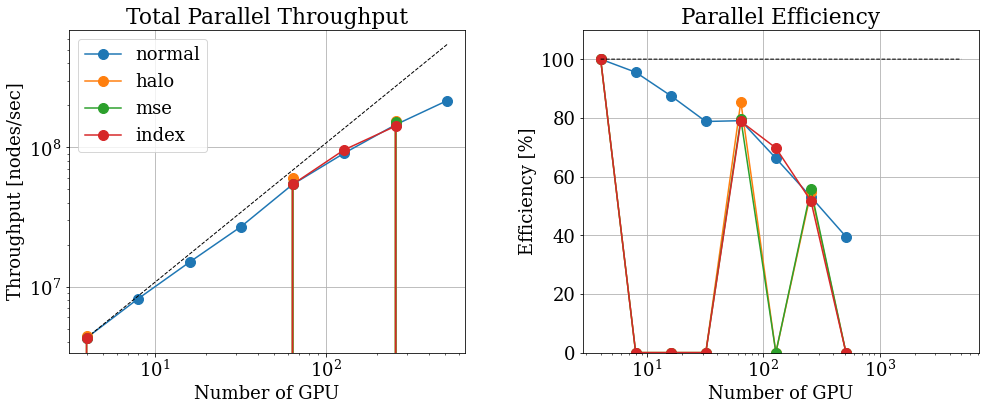

In [31]:
## DEBUG

case_dir = "polaris/500k/large/none_halo_in_tp"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
polaris_halo = NekRSML_GNN(dir_path,gpu_list)
polaris_halo.parse_files()


case_dir = "polaris/500k/large/none_mse"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
polaris_mse = NekRSML_GNN(dir_path,gpu_list)
polaris_mse.parse_files()

case_dir = "polaris/500k/large/none_no_index"
dir_path = top_dir + case_dir
gpu_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
polaris_index = NekRSML_GNN(dir_path,gpu_list)
polaris_index.parse_files()



polaris_gpu_list = [4, 8, 16, 32, 64, 128, 256, 512]
polaris_no_single_node = polaris_5_l_no.train_fom['throughput_epoch_par'][2]
polaris_no_ideal = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_no_single_node for i in range(len(polaris_gpu_list))]

polaris_halo_single_node = polaris_halo.train_fom['throughput_epoch_par'][2]
polaris_halo_ideal = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_halo_single_node for i in range(len(polaris_gpu_list))]

polaris_mse_single_node = polaris_mse.train_fom['throughput_epoch_par'][2]
polaris_mse_ideal = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_mse_single_node for i in range(len(polaris_gpu_list))]

polaris_index_single_node = polaris_index.train_fom['throughput_epoch_par'][2]
polaris_index_ideal = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_index_single_node for i in range(len(polaris_gpu_list))]


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axs[0].plot(polaris_gpu_list, polaris_5_l_no.train_fom['throughput_epoch_par'][2:],label = "normal",marker="o",ls="-",markersize=10)
axs[0].plot(polaris_gpu_list, polaris_no_ideal,c="k",ls="--",linewidth=1)
axs[0].plot(polaris_gpu_list, polaris_halo.train_fom['throughput_epoch_par'][2:],label = "halo",marker="o",ls="-",markersize=10)
axs[0].plot(polaris_gpu_list, polaris_mse.train_fom['throughput_epoch_par'][2:],label = "mse",marker="o",ls="-",markersize=10)
axs[0].plot(polaris_gpu_list, polaris_index.train_fom['throughput_epoch_par'][2:],label = "index",marker="o",ls="-",markersize=10)



axs[1].plot(polaris_gpu_list, 100*polaris_5_l_no.train_fom['throughput_epoch_par'][2:]/polaris_no_ideal,label = "",marker="o",ls="-",markersize=10)
axs[1].plot(polaris_gpu_list, 100*polaris_halo.train_fom['throughput_epoch_par'][2:]/polaris_halo_ideal,label = "",marker="o",ls="-",markersize=10)
axs[1].plot(polaris_gpu_list, 100*polaris_mse.train_fom['throughput_epoch_par'][2:]/polaris_mse_ideal,label = "",marker="o",ls="-",markersize=10)
axs[1].plot(polaris_gpu_list, 100*polaris_index.train_fom['throughput_epoch_par'][2:]/polaris_index_ideal,label = "",marker="o",ls="-",markersize=10)


axs[1].plot([i for i in range(4,5000)], [100 for i in range(4,5000)],c="k",ls="--",linewidth=1)


for i in range(2):
    axs[i].set_xscale("log")
    axs[i].grid()
    axs[i].set_xlabel('Number of GPU')

axs[0].set_yscale("log")
axs[1].set_ylim(0,110)
#fig.legend(bbox_to_anchor=(1.25,0.7))
axs[0].legend(loc='upper left')
axs[0].set_ylabel('Throughput [nodes/sec]')
axs[0].set_title('Total Parallel Throughput')
axs[1].set_ylabel('Efficiency [%]')
axs[1].set_title('Parallel Efficiency')
fig.tight_layout(pad=3.0)


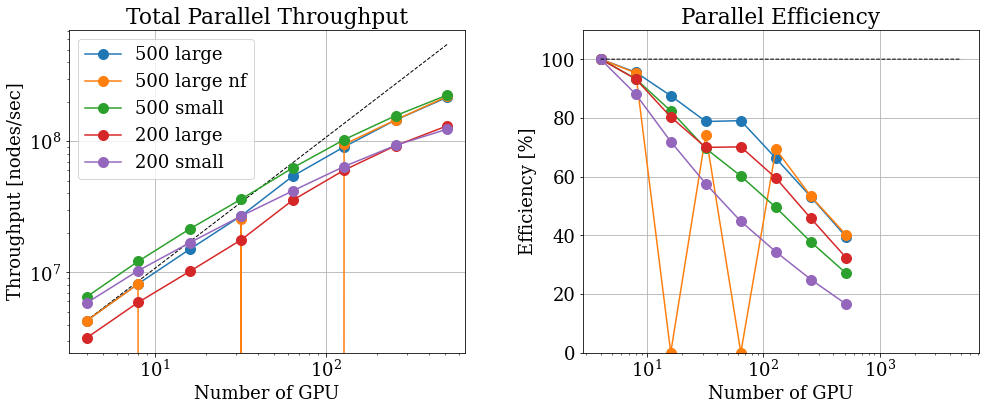

In [8]:
# Average parallel training throughput, based on epoch time, for NO HALO

polaris_gpu_list = [4, 8, 16, 32, 64, 128, 256, 512]
polaris_no_single_node = polaris_5_l_no.train_fom['throughput_epoch_par'][2]
polaris_no_ideal = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_no_single_node for i in range(len(polaris_gpu_list))]

polaris_no2_single_node = polaris_5_l_no2.train_fom['throughput_epoch_par'][2]
polaris_no2_ideal = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_no2_single_node for i in range(len(polaris_gpu_list))]

polaris_no_single_node_5s = polaris_5_s_no.train_fom['throughput_epoch_par'][2]
polaris_no_ideal_5s = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_no_single_node_5s for i in range(len(polaris_gpu_list))]

polaris_no_single_node_2l = polaris_2_l_no.train_fom['throughput_epoch_par'][2]
polaris_no_ideal_2l = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_no_single_node_2l for i in range(len(polaris_gpu_list))]

polaris_no_single_node_2s = polaris_2_s_no.train_fom['throughput_epoch_par'][2]
polaris_no_ideal_2s = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_no_single_node_2s for i in range(len(polaris_gpu_list))]



fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axs[0].plot(polaris_gpu_list, polaris_5_l_no.train_fom['throughput_epoch_par'][2:],label = "500 large",marker="o",ls="-",markersize=10)
axs[0].plot(polaris_gpu_list, polaris_no_ideal,c="k",ls="--",linewidth=1)
axs[0].plot(polaris_gpu_list, polaris_5_l_no2.train_fom['throughput_epoch_par'][2:],label = "500 large nf",marker="o",ls="-",markersize=10)
axs[0].plot(polaris_gpu_list, polaris_5_s_no.train_fom['throughput_epoch_par'][2:],label = "500 small",marker="o",ls="-",markersize=10)

axs[0].plot(polaris_gpu_list, polaris_2_l_no.train_fom['throughput_epoch_par'][2:],label = "200 large",marker="o",ls="-",markersize=10)
axs[0].plot(polaris_gpu_list, polaris_2_s_no.train_fom['throughput_epoch_par'][2:],label = "200 small",marker="o",ls="-",markersize=10)


axs[1].plot(polaris_gpu_list, 100*polaris_5_l_no.train_fom['throughput_epoch_par'][2:]/polaris_no_ideal,label = "",marker="o",ls="-",markersize=10)
axs[1].plot(polaris_gpu_list, 100*polaris_5_l_no2.train_fom['throughput_epoch_par'][2:]/polaris_no2_ideal,label = "",marker="o",ls="-",markersize=10)
axs[1].plot(polaris_gpu_list, 100*polaris_5_s_no.train_fom['throughput_epoch_par'][2:]/polaris_no_ideal_5s,label = "",marker="o",ls="-",markersize=10)
axs[1].plot(polaris_gpu_list, 100*polaris_2_l_no.train_fom['throughput_epoch_par'][2:]/polaris_no_ideal_2l,label = "",marker="o",ls="-",markersize=10)
axs[1].plot(polaris_gpu_list, 100*polaris_2_s_no.train_fom['throughput_epoch_par'][2:]/polaris_no_ideal_2s,label = "",marker="o",ls="-",markersize=10)


axs[1].plot([i for i in range(4,5000)], [100 for i in range(4,5000)],c="k",ls="--",linewidth=1)


for i in range(2):
    axs[i].set_xscale("log")
    axs[i].grid()
    axs[i].set_xlabel('Number of GPU')

axs[0].set_yscale("log")
axs[1].set_ylim(0,110)
#fig.legend(bbox_to_anchor=(1.25,0.7))
axs[0].legend(loc='upper left')
axs[0].set_ylabel('Throughput [nodes/sec]')
axs[0].set_title('Total Parallel Throughput')
axs[1].set_ylabel('Efficiency [%]')
axs[1].set_title('Parallel Efficiency')
fig.tight_layout(pad=3.0)

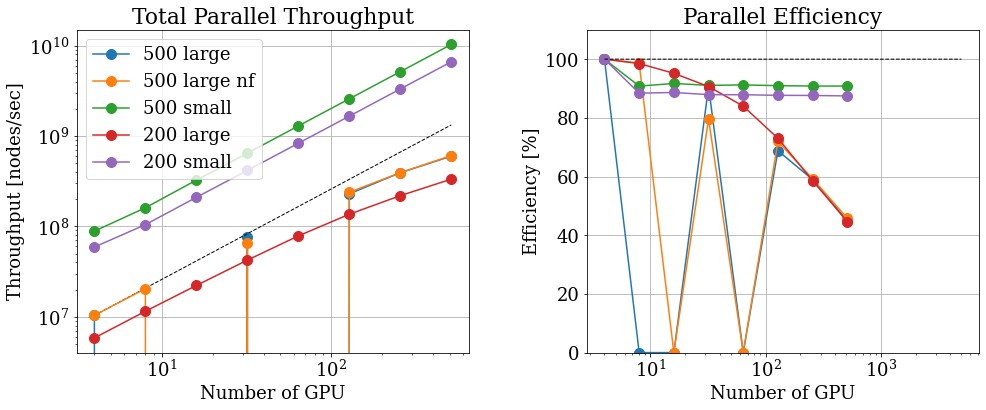

In [18]:
# Average parallel training throughput, based on batch time, for NO HALO

polaris_gpu_list = [4, 8, 16, 32, 64, 128, 256, 512]
polaris_no_single_node = polaris_5_l_no.train_fom['throughput_batch_par'][2]
polaris_no_ideal = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_no_single_node for i in range(len(polaris_gpu_list))]

polaris_no2_single_node = polaris_5_l_no2.train_fom['throughput_batch_par'][2]
polaris_no2_ideal = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_no2_single_node for i in range(len(polaris_gpu_list))]

polaris_no_single_node_5s = polaris_5_s_no.train_fom['throughput_batch_par'][2]
polaris_no_ideal_5s = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_no_single_node_5s for i in range(len(polaris_gpu_list))]

polaris_no_single_node_2l = polaris_2_l_no.train_fom['throughput_batch_par'][2]
polaris_no_ideal_2l = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_no_single_node_2l for i in range(len(polaris_gpu_list))]

polaris_no_single_node_2s = polaris_2_s_no.train_fom['throughput_batch_par'][2]
polaris_no_ideal_2s = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_no_single_node_2s for i in range(len(polaris_gpu_list))]



fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axs[0].plot(polaris_gpu_list, polaris_5_l_no.train_fom['throughput_batch_par'][2:],label = "500 large",marker="o",ls="-",markersize=10)
axs[0].plot(polaris_gpu_list, polaris_no2_ideal,c="k",ls="--",linewidth=1)
axs[0].plot(polaris_gpu_list, polaris_5_l_no2.train_fom['throughput_batch_par'][2:],label = "500 large nf",marker="o",ls="-",markersize=10)
axs[0].plot(polaris_gpu_list, polaris_5_s_no.train_fom['throughput_batch_par'][2:],label = "500 small",marker="o",ls="-",markersize=10)

axs[0].plot(polaris_gpu_list, polaris_2_l_no.train_fom['throughput_batch_par'][2:],label = "200 large",marker="o",ls="-",markersize=10)
axs[0].plot(polaris_gpu_list, polaris_2_s_no.train_fom['throughput_batch_par'][2:],label = "200 small",marker="o",ls="-",markersize=10)


axs[1].plot(polaris_gpu_list, 100*polaris_5_l_no.train_fom['throughput_batch_par'][2:]/polaris_no_ideal,label = "",marker="o",ls="-",markersize=10)
axs[1].plot(polaris_gpu_list, 100*polaris_5_l_no2.train_fom['throughput_batch_par'][2:]/polaris_no2_ideal,label = "",marker="o",ls="-",markersize=10)
axs[1].plot(polaris_gpu_list, 100*polaris_5_s_no.train_fom['throughput_batch_par'][2:]/polaris_no_ideal_5s,label = "",marker="o",ls="-",markersize=10)
axs[1].plot(polaris_gpu_list, 100*polaris_2_l_no.train_fom['throughput_batch_par'][2:]/polaris_no_ideal_2l,label = "",marker="o",ls="-",markersize=10)
axs[1].plot(polaris_gpu_list, 100*polaris_2_s_no.train_fom['throughput_batch_par'][2:]/polaris_no_ideal_2s,label = "",marker="o",ls="-",markersize=10)


axs[1].plot([i for i in range(4,5000)], [100 for i in range(4,5000)],c="k",ls="--",linewidth=1)


for i in range(2):
    axs[i].set_xscale("log")
    axs[i].grid()
    axs[i].set_xlabel('Number of GPU')

axs[0].set_yscale("log")
axs[1].set_ylim(0,110)
#fig.legend(bbox_to_anchor=(1.25,0.7))
axs[0].legend(loc='upper left')
axs[0].set_ylabel('Throughput [nodes/sec]')
axs[0].set_title('Total Parallel Throughput')
axs[1].set_ylabel('Efficiency [%]')
axs[1].set_title('Parallel Efficiency')
fig.tight_layout(pad=3.0)

In [17]:
polaris_5_l_no2.train_fom['throughput_batch_par'][2:]

array([1.035621e+07, 2.042571e+07, 0.000000e+00, 6.594759e+07,
       0.000000e+00, 2.384436e+08, 3.924567e+08, 6.070217e+08])

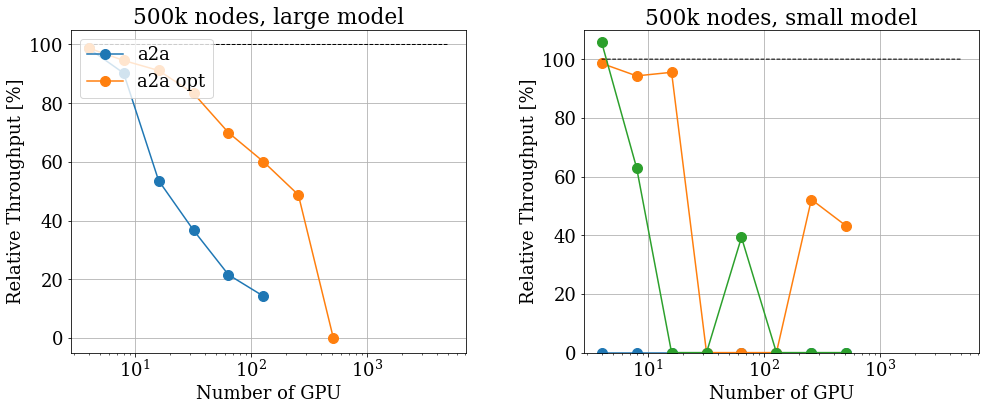

In [22]:
# Throughput relative to NO HALO, based on epoch time, for 500k

polaris_gpu_list = [4, 8, 16, 32, 64, 128, 256, 512]


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axs[0].plot([i for i in range(4,5000)], [100 for i in range(4,5000)],c="k",ls="--",linewidth=1)

axs[0].plot([4, 8, 16, 32, 64, 128], 100*polaris_5_l_a2a.train_fom['throughput_epoch_par'][2:8]/polaris_5_l_no.train_fom['throughput_epoch_par'][2:8],label = "a2a",marker="o",ls="-",markersize=10)
axs[0].plot(polaris_gpu_list, 100*polaris_5_l_a2ao.train_fom['throughput_epoch_par'][2:]/polaris_5_l_no.train_fom['throughput_epoch_par'][2:],label = "a2a opt",marker="o",ls="-",markersize=10)

axs[1].plot(polaris_gpu_list, 100*polaris_5_s_a2a.train_fom['throughput_epoch_par'][2:]/polaris_5_s_no.train_fom['throughput_epoch_par'][2:],label = "a2a",marker="o",ls="-",markersize=10)
axs[1].plot(polaris_gpu_list, 100*polaris_5_s_a2ao.train_fom['throughput_epoch_par'][2:]/polaris_5_s_no.train_fom['throughput_epoch_par'][2:],label = "a2a opt",marker="o",ls="-",markersize=10)
axs[1].plot(polaris_gpu_list, 100*polaris_5_s_sr.train_fom['throughput_epoch_par'][2:]/polaris_5_s_no.train_fom['throughput_epoch_par'][2:],label = "send-recv",marker="o",ls="-",markersize=10)
axs[1].plot([i for i in range(4,5000)], [100 for i in range(4,5000)],c="k",ls="--",linewidth=1)


for i in range(2):
    axs[i].set_xscale("log")
    axs[i].grid()
    axs[i].set_xlabel('Number of GPU')

axs[1].set_ylim(0,110)
#fig.legend(bbox_to_anchor=(1.25,0.7))
axs[0].legend(loc='upper left')
axs[0].set_ylabel('Relative Throughput [%]')
axs[1].set_ylabel('Relative Throughput [%]')
axs[0].set_title('500k nodes, large model')
axs[1].set_title('500k nodes, small model')
fig.tight_layout(pad=3.0)

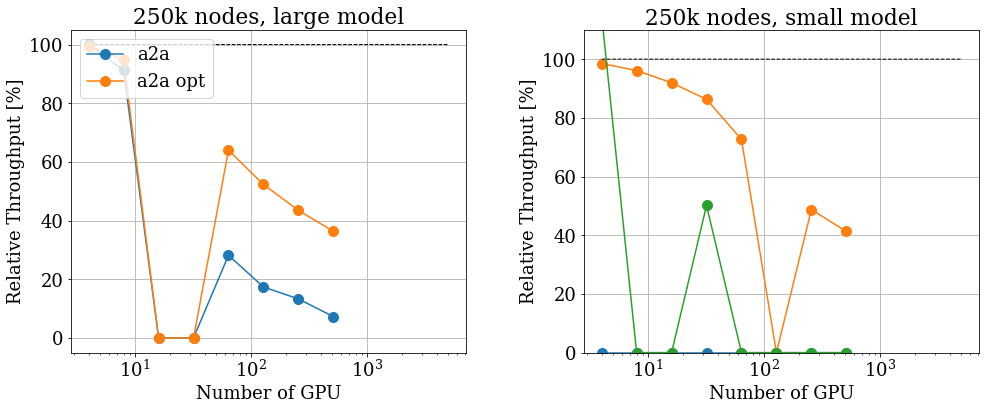

In [19]:
# Throughput relative to NO HALO, based on epoch time, for 250k

polaris_gpu_list = [4, 8, 16, 32, 64, 128, 256, 512]


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axs[0].plot([i for i in range(4,5000)], [100 for i in range(4,5000)],c="k",ls="--",linewidth=1)

axs[0].plot(polaris_gpu_list, 100*polaris_2_l_a2a.train_fom['throughput_epoch_par'][2:]/polaris_2_l_no.train_fom['throughput_epoch_par'][2:],label = "a2a",marker="o",ls="-",markersize=10)
axs[0].plot(polaris_gpu_list, 100*polaris_2_l_a2ao.train_fom['throughput_epoch_par'][2:]/polaris_2_l_no.train_fom['throughput_epoch_par'][2:],label = "a2a opt",marker="o",ls="-",markersize=10)


axs[1].plot(polaris_gpu_list, 100*polaris_2_s_a2a.train_fom['throughput_epoch_par'][2:]/polaris_2_s_no.train_fom['throughput_epoch_par'][2:],label = "a2a",marker="o",ls="-",markersize=10)
axs[1].plot(polaris_gpu_list, 100*polaris_2_s_a2ao.train_fom['throughput_epoch_par'][2:]/polaris_2_s_no.train_fom['throughput_epoch_par'][2:],label = "a2a opt",marker="o",ls="-",markersize=10)
axs[1].plot(polaris_gpu_list, 100*polaris_2_s_sr.train_fom['throughput_epoch_par'][2:]/polaris_2_s_no.train_fom['throughput_epoch_par'][2:],label = "send-recv",marker="o",ls="-",markersize=10)
axs[1].plot([i for i in range(4,5000)], [100 for i in range(4,5000)],c="k",ls="--",linewidth=1)


for i in range(2):
    axs[i].set_xscale("log")
    axs[i].grid()
    axs[i].set_xlabel('Number of GPU')

axs[1].set_ylim(0,110)
#fig.legend(bbox_to_anchor=(1.25,0.7))
axs[0].legend(loc='upper left')
axs[0].set_ylabel('Relative Throughput [%]')
axs[1].set_ylabel('Relative Throughput [%]')
axs[0].set_title('250k nodes, large model')
axs[1].set_title('250k nodes, small model')
fig.tight_layout(pad=3.0)

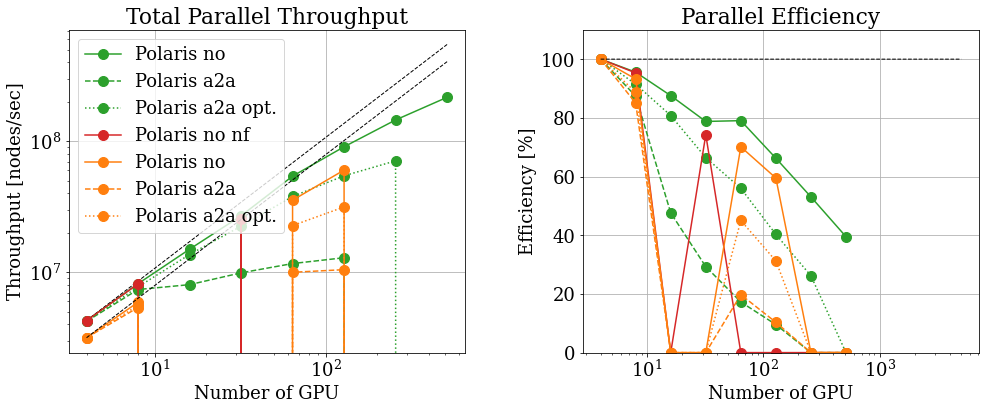

In [31]:
# Average parallel training throughput, based on epoch time

polaris_gpu_list = [4, 8, 16, 32, 64, 128, 256, 512]
polaris_no_single_node = polaris_5_l_no.train_fom['throughput_epoch_par'][2]
polaris_no_ideal = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_no_single_node for i in range(len(polaris_gpu_list))]
polaris_a2a_single_node = polaris_5_l_a2a.train_fom['throughput_epoch_par'][2]
polaris_a2a_ideal = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_a2a_single_node for i in range(len(polaris_gpu_list))]
polaris_a2ao_single_node = polaris_5_l_a2ao.train_fom['throughput_epoch_par'][2]
polaris_a2ao_ideal = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_a2ao_single_node for i in range(len(polaris_gpu_list))]

polaris_no2_single_node = polaris_5_l_no2.train_fom['throughput_epoch_par'][2]
polaris_no2_ideal = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_no2_single_node for i in range(len(polaris_gpu_list))]

polaris_no_single_node2 = polaris_2_l_no.train_fom['throughput_epoch_par'][2]
polaris_no_ideal2 = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_no_single_node2 for i in range(len(polaris_gpu_list))]
polaris_a2a_single_node2 = polaris_2_l_a2a.train_fom['throughput_epoch_par'][2]
polaris_a2a_ideal2 = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_a2a_single_node2 for i in range(len(polaris_gpu_list))]
polaris_a2ao_single_node2 = polaris_2_l_a2ao.train_fom['throughput_epoch_par'][2]
polaris_a2ao_ideal2 = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_a2ao_single_node2 for i in range(len(polaris_gpu_list))]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axs[0].plot(polaris_gpu_list, polaris_5_l_no.train_fom['throughput_epoch_par'][2:],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[0].plot(polaris_gpu_list, polaris_5_l_a2a.train_fom['throughput_epoch_par'][2:],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs[0].plot(polaris_gpu_list, polaris_5_l_a2ao.train_fom['throughput_epoch_par'][2:],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')
axs[0].plot(polaris_gpu_list, polaris_no_ideal,c="k",ls="--",linewidth=1)

axs[0].plot(polaris_gpu_list, polaris_5_l_no2.train_fom['throughput_epoch_par'][2:],label = "Polaris no nf",marker="o",ls="-",markersize=10,color='tab:red')


axs[0].plot(polaris_gpu_list, polaris_2_l_no.train_fom['throughput_epoch_par'][2:],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:orange')
axs[0].plot(polaris_gpu_list, polaris_2_l_a2a.train_fom['throughput_epoch_par'][2:],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:orange')
axs[0].plot(polaris_gpu_list, polaris_2_l_a2ao.train_fom['throughput_epoch_par'][2:],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:orange')
axs[0].plot(polaris_gpu_list, polaris_no_ideal2,c="k",ls="--",linewidth=1)

axs[1].plot(polaris_gpu_list, 100*polaris_5_l_no.train_fom['throughput_epoch_par'][2:]/polaris_no_ideal,label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[1].plot(polaris_gpu_list, 100*polaris_5_l_a2a.train_fom['throughput_epoch_par'][2:]/polaris_a2a_ideal,label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs[1].plot(polaris_gpu_list, 100*polaris_5_l_a2ao.train_fom['throughput_epoch_par'][2:]/polaris_a2ao_ideal,label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[1].plot(polaris_gpu_list, 100*polaris_5_l_no2.train_fom['throughput_epoch_par'][2:]/polaris_no2_ideal,label = "Polaris no nf",marker="o",ls="-",markersize=10,color='tab:red')

axs[1].plot(polaris_gpu_list, 100*polaris_2_l_no.train_fom['throughput_epoch_par'][2:]/polaris_no_ideal2,label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:orange')
axs[1].plot(polaris_gpu_list, 100*polaris_2_l_a2a.train_fom['throughput_epoch_par'][2:]/polaris_a2a_ideal2,label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:orange')
axs[1].plot(polaris_gpu_list, 100*polaris_2_l_a2ao.train_fom['throughput_epoch_par'][2:]/polaris_a2ao_ideal2,label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:orange')
axs[1].plot([i for i in range(4,5000)], [100 for i in range(4,5000)],c="k",ls="--",linewidth=1)


for i in range(2):
    axs[i].set_xscale("log")
    axs[i].grid()
    axs[i].set_xlabel('Number of GPU')

axs[0].set_yscale("log")
axs[1].set_ylim(0,110)
#fig.legend(bbox_to_anchor=(1.25,0.7))
axs[0].legend(loc='upper left')
axs[0].set_ylabel('Throughput [nodes/sec]')
axs[0].set_title('Total Parallel Throughput')
axs[1].set_ylabel('Efficiency [%]')
axs[1].set_title('Parallel Efficiency')
fig.tight_layout(pad=3.0)

/var/folders/k4/q8s435wd1c3b4fv_2zqcsj0h0000gn/T/ipykernel_20487/796419042.py:39: RuntimeWarning: divide by zero encountered in divide
  axs[1].plot(polaris_gpu_list, polaris_a2a.train_fom['throughput_batch_par'][2:]/polaris_a2a_ideal,label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
/var/folders/k4/q8s435wd1c3b4fv_2zqcsj0h0000gn/T/ipykernel_20487/796419042.py:39: RuntimeWarning: invalid value encountered in divide
  axs[1].plot(polaris_gpu_list, polaris_a2a.train_fom['throughput_batch_par'][2:]/polaris_a2a_ideal,label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
/var/folders/k4/q8s435wd1c3b4fv_2zqcsj0h0000gn/T/ipykernel_20487/796419042.py:40: RuntimeWarning: divide by zero encountered in divide
  axs[1].plot(polaris_gpu_list, polaris_a2ao.train_fom['throughput_batch_par'][2:]/polaris_a2ao_ideal,label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')
/var/folders/k4/q8s435wd1c3b4fv_2zqcsj0h0000gn/T/ipykernel_20487/796

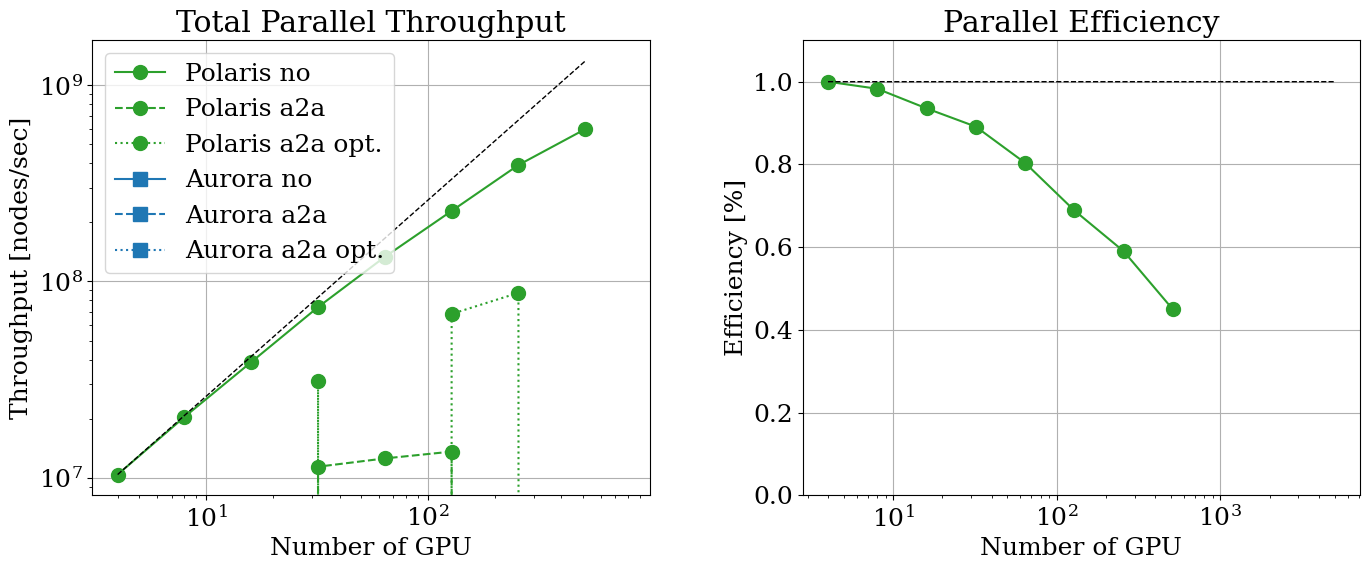

In [32]:
# Average parallel training throughput, based on batch time

polaris_gpu_list = [4, 8, 16, 32, 64, 128, 256, 512]
polaris_graph_nodes = [518400, 518400, 528080, 528080, 539601, 539601, 535685, 535685]
for i in range(len(polaris_gpu_list)):
    if polaris_no.train_fom['throughput_batch_par'][2+i] == 0:
        polaris_no.train_fom['throughput_batch_par'][2+i] = polaris_graph_nodes[i]*polaris_gpu_list[i]/polaris_no.train_fom['train_batch'][2+i,2]
        


polaris_no_single_node = polaris_no.train_fom['throughput_batch_par'][2]
polaris_no_ideal = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_no_single_node for i in range(len(polaris_gpu_list))]
polaris_a2a_single_node = polaris_a2a.train_fom['throughput_batch_par'][2]
polaris_a2a_ideal = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_a2a_single_node for i in range(len(polaris_gpu_list))]
polaris_a2ao_single_node = polaris_a2ao.train_fom['throughput_batch_par'][2]
polaris_a2ao_ideal = [polaris_gpu_list[i]/polaris_gpu_list[0]*polaris_a2ao_single_node for i in range(len(polaris_gpu_list))]

aurora_gpu_list = [6, 12, 24, 48, 96, 192, 384, 768]
aurora_no_single_node = aurora_no.train_fom['throughput_batch_par'][3]
aurora_no_ideal = [aurora_gpu_list[i]/aurora_gpu_list[0]*aurora_no_single_node for i in range(len(aurora_gpu_list))]
aurora_a2a_single_node = aurora_a2a.train_fom['throughput_batch_par'][3]
aurora_a2a_ideal = [aurora_gpu_list[i]/aurora_gpu_list[0]*aurora_a2a_single_node for i in range(len(aurora_gpu_list))]
aurora_a2ao_single_node = aurora_a2ao.train_fom['throughput_batch_par'][3]
aurora_a2ao_ideal = [aurora_gpu_list[i]/aurora_gpu_list[0]*aurora_a2ao_single_node for i in range(len(aurora_gpu_list))]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axs[0].plot(polaris_gpu_list, polaris_no.train_fom['throughput_batch_par'][2:],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[0].plot(polaris_gpu_list, polaris_a2a.train_fom['throughput_batch_par'][2:],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs[0].plot(polaris_gpu_list, polaris_a2ao.train_fom['throughput_batch_par'][2:],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')
axs[0].plot(polaris_gpu_list, polaris_no_ideal,c="k",ls="--",linewidth=1)

axs[0].plot(aurora_gpu_list, aurora_no.train_fom['throughput_batch_par'][3:],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[0].plot(aurora_gpu_list, aurora_a2a.train_fom['throughput_batch_par'][3:],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[0].plot(aurora_gpu_list, aurora_a2ao.train_fom['throughput_batch_par'][3:],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')
axs[0].plot(aurora_gpu_list, aurora_no_ideal,c="k",ls="--",linewidth=1)


axs[1].plot(polaris_gpu_list, polaris_no.train_fom['throughput_batch_par'][2:]/polaris_no_ideal,label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[1].plot(polaris_gpu_list, polaris_a2a.train_fom['throughput_batch_par'][2:]/polaris_a2a_ideal,label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs[1].plot(polaris_gpu_list, polaris_a2ao.train_fom['throughput_batch_par'][2:]/polaris_a2ao_ideal,label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[1].plot(aurora_gpu_list, aurora_no.train_fom['throughput_batch_par'][3:]/aurora_no_ideal,label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[1].plot(aurora_gpu_list, aurora_a2a.train_fom['throughput_batch_par'][3:]/aurora_a2a_ideal,label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[1].plot(aurora_gpu_list, aurora_a2ao.train_fom['throughput_batch_par'][3:]/aurora_a2ao_ideal,label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')
axs[1].plot([i for i in range(4,5000)], [1 for i in range(4,5000)],c="k",ls="--",linewidth=1)


for i in range(2):
    axs[i].set_xscale("log")
    axs[i].grid()
    axs[i].set_xlabel('Number of GPU')

axs[0].set_yscale("log")
axs[1].set_ylim(0,1.1)
#fig.legend(bbox_to_anchor=(1.25,0.7))
axs[0].legend(loc='upper left')
axs[0].set_ylabel('Throughput [nodes/sec]')
axs[0].set_title('Total Parallel Throughput')
axs[1].set_ylabel('Efficiency [%]')
axs[1].set_title('Parallel Efficiency')
fig.tight_layout(pad=3.0)

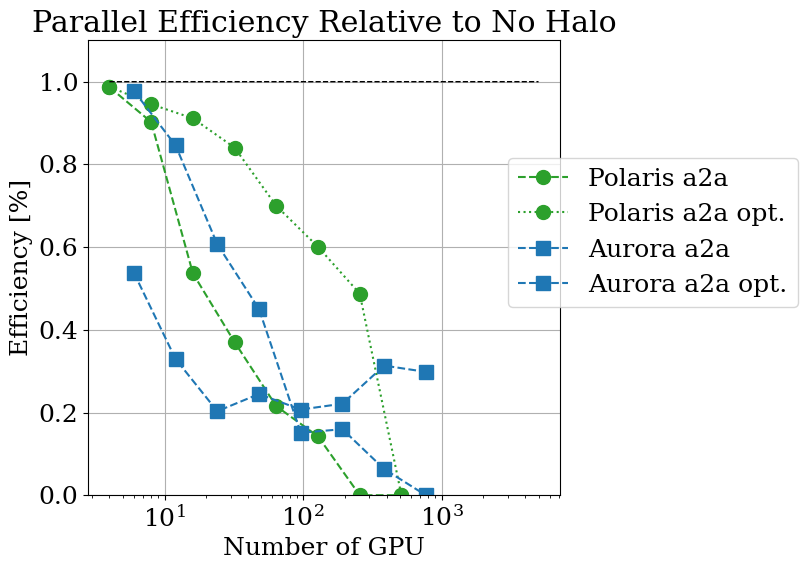

In [69]:
# Average parallel training throughput, relative to model run with no halo exchange

polaris_gpu_list = [4, 8, 16, 32, 64, 128, 256, 512]
aurora_gpu_list = [6, 12, 24, 48, 96, 192, 384, 768]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
axs.plot(polaris_gpu_list, polaris_a2a.train_fom['throughput_epoch_par'][2:]/polaris_no.train_fom['throughput_epoch_par'][2:],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs.plot(polaris_gpu_list, polaris_a2ao.train_fom['throughput_epoch_par'][2:]/polaris_no.train_fom['throughput_epoch_par'][2:],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs.plot(aurora_gpu_list, aurora_a2a.train_fom['throughput_epoch_par'][3:]/aurora_no.train_fom['throughput_epoch_par'][3:],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs.plot(aurora_gpu_list, aurora_a2ao.train_fom['throughput_epoch_par'][3:]/aurora_no.train_fom['throughput_epoch_par'][3:],label = "Aurora a2a opt.",marker="s",ls="--",markersize=10,color='tab:blue')
axs.plot([i for i in range(4,5000)], [1 for i in range(4,5000)],c="k",ls="--",linewidth=1)

axs.set_xscale("log")
axs.grid()
axs.set_xlabel('Number of GPU')

fig.legend(bbox_to_anchor=(1.25,0.7))
axs.set_ylim(0,1.1)
axs.set_ylabel('Efficiency [%]')
axs.set_title('Parallel Efficiency Relative to No Halo')
fig.tight_layout(pad=3.0)

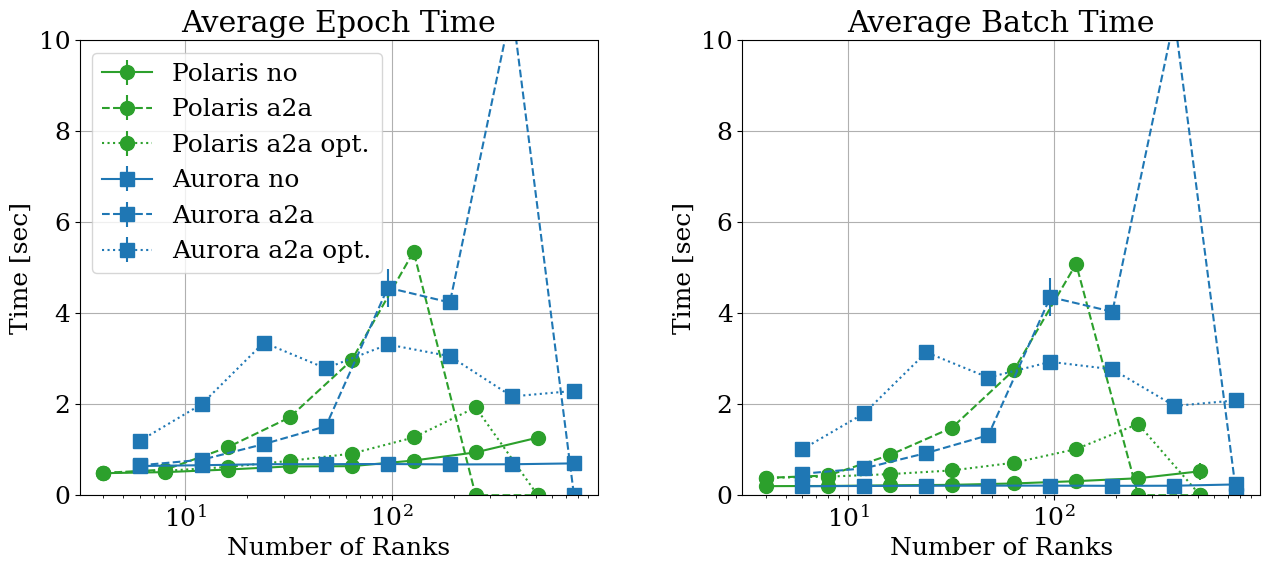

In [70]:
# Epoch and batch timings, and their difference

polaris_gpu_list = [4, 8, 16, 32, 64, 128, 256, 512]
aurora_gpu_list = [6, 12, 24, 48, 96, 192, 384, 768]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axs[0].errorbar(polaris_gpu_list, polaris_no.train_fom['train_epoch'][2:,2],polaris_no.train_fom['train_epoch'][2:,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
axs[0].errorbar(polaris_gpu_list, polaris_a2a.train_fom['train_epoch'][2:,2],polaris_a2a.train_fom['train_epoch'][2:,3],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs[0].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['train_epoch'][2:,2],polaris_a2ao.train_fom['train_epoch'][2:,3],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[0].errorbar(aurora_gpu_list, aurora_no.train_fom['train_epoch'][3:,2],aurora_no.train_fom['train_epoch'][3:,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[0].errorbar(aurora_gpu_list, aurora_a2a.train_fom['train_epoch'][3:,2],aurora_a2a.train_fom['train_epoch'][3:,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[0].errorbar(aurora_gpu_list, aurora_a2ao.train_fom['train_epoch'][3:,2],aurora_a2ao.train_fom['train_epoch'][3:,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')


axs[1].errorbar(polaris_gpu_list, polaris_no.train_fom['train_batch'][2:,2],polaris_no.train_fom['train_batch'][2:,3],label = "Polaris",marker="o",ls="-",markersize=10,color='tab:green')
axs[1].errorbar(polaris_gpu_list, polaris_a2a.train_fom['train_batch'][2:,2],polaris_a2a.train_fom['train_batch'][2:,3],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
axs[1].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['train_batch'][2:,2],polaris_a2ao.train_fom['train_batch'][2:,3],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[1].errorbar(aurora_gpu_list, aurora_no.train_fom['train_batch'][3:,2],aurora_no.train_fom['train_batch'][3:,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
axs[1].errorbar(aurora_gpu_list, aurora_a2a.train_fom['train_batch'][3:,2],aurora_a2a.train_fom['train_batch'][3:,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
axs[1].errorbar(aurora_gpu_list, aurora_a2ao.train_fom['train_batch'][3:,2],aurora_a2ao.train_fom['train_batch'][3:,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')

for j in range(2):
    axs[j].set_xscale("log")
    axs[j].grid()
    axs[j].set_xlabel('Number of Ranks')
    axs[j].set_ylabel('Time [sec]')
    axs[j].set_ylim(0,10)
    
axs[0].legend(loc='upper left')
axs[0].set_title('Average Epoch Time')
axs[1].set_title('Average Batch Time')
fig.tight_layout(pad=3.0)

#fig1, axs1 = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
#axs1.plot(polaris_gpu_list, polaris_no.train_fom['train_epoch'][2:,2]-polaris_no.train_fom['train_batch'][2:,2],label = "Polaris no",marker="o",ls="-",markersize=10)
#axs1.plot(polaris_gpu_list, polaris_a2a.train_fom['train_epoch'][2:,2]-polaris_a2a.train_fom['train_batch'][2:,2],label = "Polaris a2a",marker="o",ls="-",markersize=10)
#axs1.plot(polaris_gpu_list, polaris_a2ao.train_fom['train_epoch'][2:,2]-polaris_a2ao.train_fom['train_batch'][2:,2],label = "Polaris a2a opt.",marker="o",ls="-",markersize=10)

#axs1.set_xscale("log")
#axs1.grid()
#axs1.set_xlabel('Number of Ranks')
#axs1.set_ylabel('Time [sec]')
#axs1.set_ylim(0.01,0.025)
#axs1.legend(loc='lower right')
#axs1.set_title('Difference between Epoch and Batch Time')


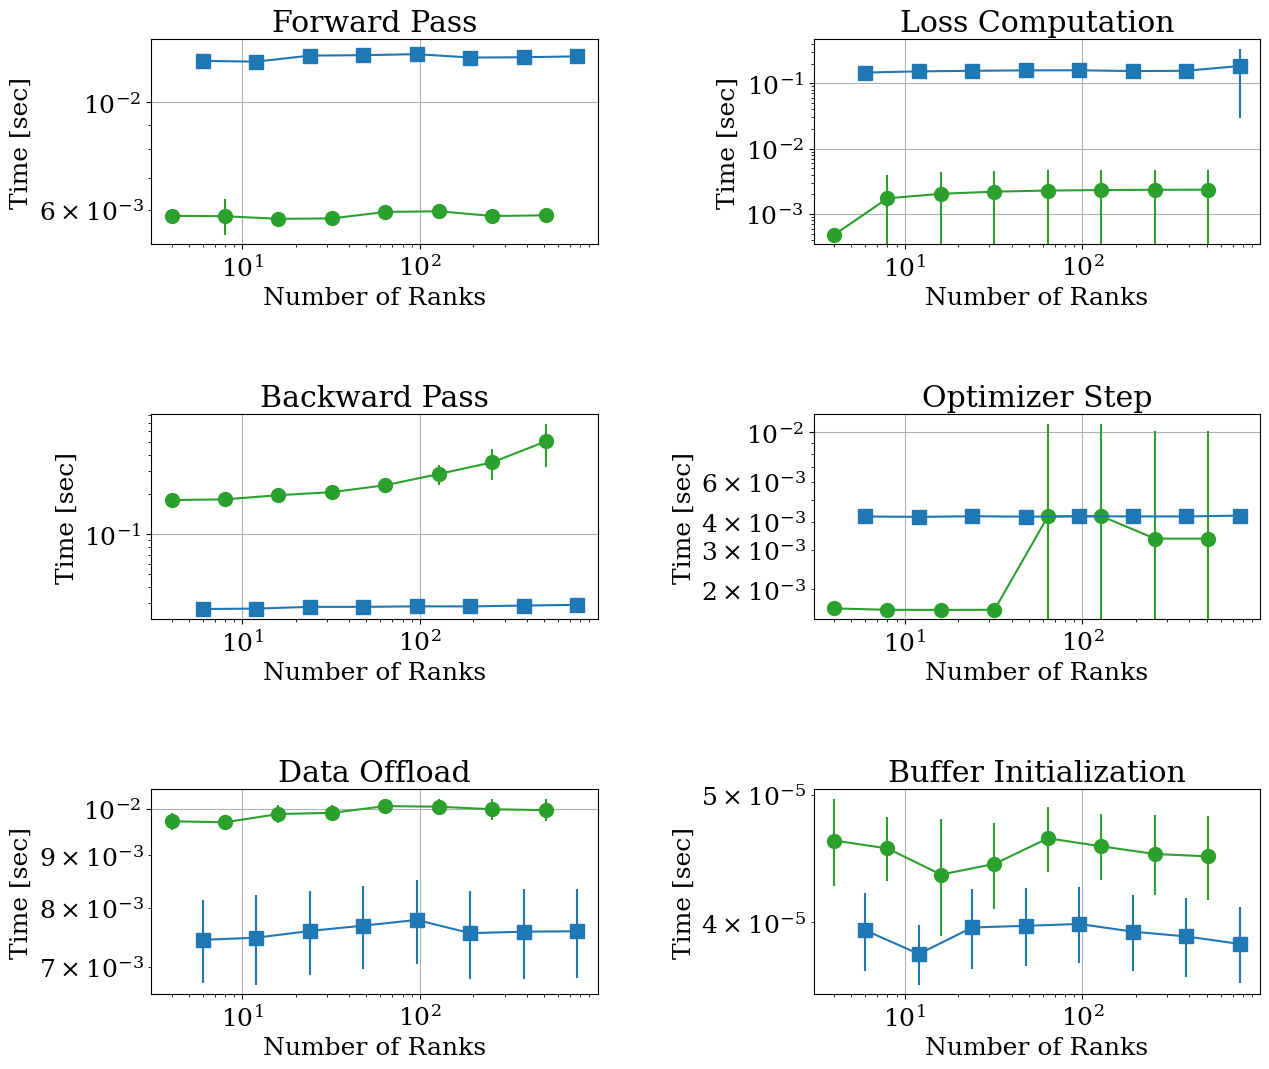

In [52]:
# Iteration timings

polaris_gpu_list = [4, 8, 16, 32, 64, 128, 256, 512]
aurora_gpu_list = [6, 12, 24, 48, 96, 192, 384, 768]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
axs[0,0].errorbar(polaris_gpu_list, polaris_no.train_fom['forward_pass'][2:,2],polaris_no.train_fom['forward_pass'][2:,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
#axs[0,0].errorbar(polaris_gpu_list, polaris_a2a.train_fom['forward_pass'][2:,2],polaris_a2a.train_fom['forward_pass'][2:,3],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
#axs[0,0].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['forward_pass'][2:,2],polaris_a2ao.train_fom['forward_pass'][2:,3],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[0,0].errorbar(aurora_gpu_list, aurora_no.train_fom['forward_pass'][3:,2],aurora_no.train_fom['forward_pass'][3:,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
#axs[0,0].errorbar(aurora_gpu_list, aurora_a2a.train_fom['forward_pass'][3:,2],aurora_a2a.train_fom['forward_pass'][3:,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
#axs[0,0].errorbar(aurora_gpu_list, aurora_a2ao.train_fom['forward_pass'][3:,2],aurora_a2ao.train_fom['forward_pass'][3:,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')


axs[0,1].errorbar(polaris_gpu_list, polaris_no.train_fom['loss'][2:,2],polaris_no.train_fom['loss'][2:,3],label = "Polaris",marker="o",ls="-",markersize=10,color='tab:green')
#axs[0,1].errorbar(polaris_gpu_list, polaris_a2a.train_fom['loss'][2:,2],polaris_a2a.train_fom['loss'][2:,3],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
#axs[0,1].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['loss'][2:,2],polaris_a2ao.train_fom['loss'][2:,3],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[0,1].errorbar(aurora_gpu_list, aurora_no.train_fom['loss'][3:,2],aurora_no.train_fom['loss'][3:,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
#axs[0,1].errorbar(aurora_gpu_list, aurora_a2a.train_fom['loss'][3:,2],aurora_a2a.train_fom['loss'][3:,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
#axs[0,1].errorbar(aurora_gpu_list, aurora_a2ao.train_fom['loss'][3:,2],aurora_a2ao.train_fom['loss'][3:,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')


axs[1,0].errorbar(polaris_gpu_list, polaris_no.train_fom['backward_pass'][2:,2],polaris_no.train_fom['backward_pass'][2:,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
#axs[1,0].errorbar(polaris_gpu_list, polaris_a2a.train_fom['backward_pass'][2:,2],polaris_a2a.train_fom['backward_pass'][2:,3],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
#axs[1,0].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['backward_pass'][2:,2],polaris_a2ao.train_fom['backward_pass'][2:,3],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[1,0].errorbar(aurora_gpu_list, aurora_no.train_fom['backward_pass'][3:,2],aurora_no.train_fom['backward_pass'][3:,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
#axs[1,0].errorbar(aurora_gpu_list, aurora_a2a.train_fom['backward_pass'][3:,2],aurora_a2a.train_fom['backward_pass'][3:,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
#axs[1,0].errorbar(aurora_gpu_list, aurora_a2ao.train_fom['backward_pass'][3:,2],aurora_a2ao.train_fom['backward_pass'][3:,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')


axs[1,1].errorbar(polaris_gpu_list, polaris_no.train_fom['optimizer_step'][2:,2],polaris_no.train_fom['optimizer_step'][2:,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
#axs[1,1].errorbar(polaris_gpu_list, polaris_a2a.train_fom['optimizer_step'][2:,2],polaris_a2a.train_fom['optimizer_step'][2:,3],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
#axs[1,1].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['optimizer_step'][2:,2],polaris_a2ao.train_fom['optimizer_step'][2:,3],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[1,1].errorbar(aurora_gpu_list, aurora_no.train_fom['optimizer_step'][3:,2],aurora_no.train_fom['optimizer_step'][3:,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
#axs[1,1].errorbar(aurora_gpu_list, aurora_a2a.train_fom['optimizer_step'][3:,2],aurora_a2a.train_fom['optimizer_step'][3:,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
#axs[1,1].errorbar(aurora_gpu_list, aurora_a2ao.train_fom['optimizer_step'][3:,2],aurora_a2ao.train_fom['optimizer_step'][3:,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')


axs[2,0].errorbar(polaris_gpu_list, polaris_no.train_fom['data_offload'][2:,2],polaris_no.train_fom['data_offload'][2:,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
#axs[2,0].errorbar(polaris_gpu_list, polaris_a2a.train_fom['data_offload'][2:,2],polaris_a2a.train_fom['data_offload'][2:,3],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
#axs[2,0].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['data_offload'][2:,2],polaris_a2ao.train_fom['data_offload'][2:,3],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[2,0].errorbar(aurora_gpu_list, aurora_no.train_fom['data_offload'][3:,2],aurora_no.train_fom['data_offload'][3:,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
#axs[2,0].errorbar(aurora_gpu_list, aurora_a2a.train_fom['data_offload'][3:,2],aurora_a2a.train_fom['data_offload'][3:,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
#axs[2,0].errorbar(aurora_gpu_list, aurora_a2ao.train_fom['data_offload'][3:,2],aurora_a2ao.train_fom['data_offload'][3:,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')


axs[2,1].errorbar(polaris_gpu_list, polaris_no.train_fom['buffer_init'][2:,2],polaris_no.train_fom['buffer_init'][2:,3],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
#axs[2,1].errorbar(polaris_gpu_list, polaris_a2a.train_fom['buffer_init'][2:,2],polaris_a2a.train_fom['buffer_init'][2:,3],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
#axs[2,1].errorbar(polaris_gpu_list, polaris_a2ao.train_fom['buffer_init'][2:,2],polaris_a2ao.train_fom['buffer_init'][2:,3],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[2,1].errorbar(aurora_gpu_list, aurora_no.train_fom['buffer_init'][3:,2],aurora_no.train_fom['buffer_init'][3:,3],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
#axs[2,1].errorbar(aurora_gpu_list, aurora_a2a.train_fom['buffer_init'][3:,2],aurora_a2a.train_fom['buffer_init'][3:,3],label = "Aurora a2a",marker="s",ls="--",markersize=10,color='tab:blue')
#axs[2,1].errorbar(aurora_gpu_list, aurora_a2ao.train_fom['buffer_init'][3:,2],aurora_a2ao.train_fom['buffer_init'][3:,3],label = "Aurora a2a opt.",marker="s",ls=":",markersize=10,color='tab:blue')


for i in range(3):
    for j in range(2):
        axs[i,j].set_xscale("log")
        axs[i,j].set_yscale("log")
        axs[i,j].grid()
        axs[i,j].set_xlabel('Number of Ranks')
        axs[i,j].set_ylabel('Time [sec]')

axs[0,0].set_title('Forward Pass')
axs[0,1].set_title('Loss Computation')
axs[1,0].set_title('Backward Pass')
axs[1,1].set_title('Optimizer Step')
axs[2,0].set_title('Data Offload')
axs[2,1].set_title('Buffer Initialization')
fig.tight_layout(pad=3.0)

In [23]:
# Backward pass efficiency

polaris_gpu_list = [4, 8, 16, 32, 64, 128, 256, 512]
aurora_gpu_list = [6, 12, 24, 48, 96, 192, 384, 768]

#print(polaris_no.train_fom['backward_pass'][2,2]/polaris_no.train_fom['backward_pass'][2:,2])
print(polaris_a2a.train_fom['backward_pass'][2:,2])
##print("")
#print(aurora_no.train_fom['backward_pass'][3,2]/aurora_no.train_fom['backward_pass'][3:,2])
#print(aurora_no.train_fom['backward_pass'][3:,2])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
axs[0].plot(polaris_gpu_list, polaris_no.train_fom['forward_pass'][2,2]/polaris_no.train_fom['forward_pass'][2:,2],label = "Polaris no",marker="o",ls="-",markersize=10,color='tab:green')
#axs[0].plot(polaris_gpu_list, polaris_a2a.train_fom['forward_pass'][2,2]/polaris_a2a.train_fom['forward_pass'][2:,2],label = "Polaris a2a",marker="o",ls="--",markersize=10,color='tab:green')
#axs[0].plot(polaris_gpu_list, polaris_a2ao.train_fom['forward_pass'][2,2]/polaris_a2ao.train_fom['forward_pass'][2:,2],label = "Polaris a2a opt.",marker="o",ls=":",markersize=10,color='tab:green')

axs[0].plot(aurora_gpu_list, aurora_no.train_fom['forward_pass'][3,2]/aurora_no.train_fom['forward_pass'][3:,2],label = "Aurora no",marker="s",ls="-",markersize=10,color='tab:blue')
#axs[0].plot(aurora_gpu_list, aurora_a2a.train_fom['forward_pass'][3,2]/aurora_a2a.train_fom['forward_pass'][3:,2],label = "Aurora no",marker="s",ls="--",markersize=10,color='tab:blue')
#axs[0].plot(aurora_gpu_list, aurora_a2ao.train_fom['forward_pass'][3,2]/aurora_a2ao.train_fom['forward_pass'][3:,2],label = "Aurora no",marker="s",ls=":",markersize=10,color='tab:blue')


axs[1].plot(polaris_gpu_list, polaris_no.train_fom['backward_pass'][2,2]/polaris_no.train_fom['backward_pass'][2:,2],marker="o",ls="-",markersize=10,color='tab:green')
#axs[1].plot(polaris_gpu_list, polaris_a2a.train_fom['backward_pass'][2,2]/polaris_a2a.train_fom['backward_pass'][2:,2],marker="o",ls="--",markersize=10,color='tab:green')
#axs[1].plot(polaris_gpu_list, polaris_a2ao.train_fom['backward_pass'][2,2]/polaris_a2ao.train_fom['backward_pass'][2:,2],marker="o",ls=":",markersize=10,color='tab:green')

axs[1].plot(aurora_gpu_list, aurora_no.train_fom['backward_pass'][3,2]/aurora_no.train_fom['backward_pass'][3:,2],marker="s",ls="-",markersize=10,color='tab:blue')
#axs[1].plot(aurora_gpu_list, aurora_a2a.train_fom['backward_pass'][3,2]/aurora_a2a.train_fom['backward_pass'][3:,2],marker="s",ls="--",markersize=10,color='tab:blue')
#axs[1].plot(aurora_gpu_list, aurora_a2ao.train_fom['backward_pass'][3,2]/aurora_a2ao.train_fom['backward_pass'][3:,2],marker="s",ls=":",markersize=10,color='tab:blue')



#axs.set_yscale("log")
for i in range(2):
    axs[i].set_xscale("log")
    axs[i].grid()
    axs[i].set_xlabel('Number of GPU')
    axs[i].set_ylabel('Efficiency [%]')
    axs[i].set_ylim(0,1.1)

axs[0].set_title('Forward Pass Scaling Efficiency')
axs[1].set_title('Backward Pass Scaling Efficiency')
fig.tight_layout(pad=3.0)
fig.legend(bbox_to_anchor=(0.7,0.1),ncol=2)

NameError: name 'polaris_a2a' is not defined

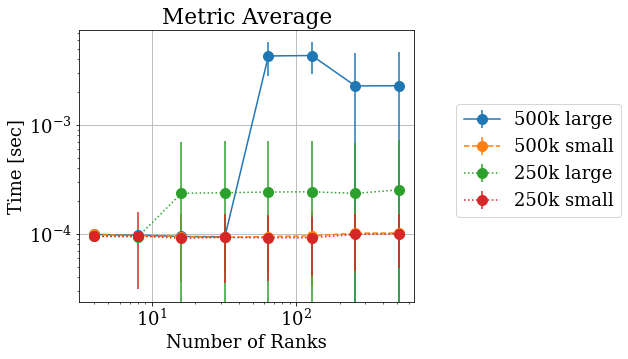

In [12]:
# Metric average for loss

polaris_gpu_list = [4, 8, 16, 32, 64, 128, 256, 512]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
axs.errorbar(polaris_gpu_list, polaris_5_l_no.train_fom['collectives'][2:,2],polaris_5_l_no.train_fom['collectives'][2:,3],label = "500k large",marker="o",ls="-",markersize=10)
axs.errorbar(polaris_gpu_list, polaris_5_s_no.train_fom['collectives'][2:,2],polaris_5_s_no.train_fom['collectives'][2:,3],label = "500k small",marker="o",ls="--",markersize=10)
axs.errorbar(polaris_gpu_list, polaris_2_l_no.train_fom['collectives'][2:,2],polaris_2_l_no.train_fom['collectives'][2:,3],label = "250k large",marker="o",ls=":",markersize=10)
axs.errorbar(polaris_gpu_list, polaris_2_s_no.train_fom['collectives'][2:,2],polaris_2_s_no.train_fom['collectives'][2:,3],label = "250k small",marker="o",ls=":",markersize=10)

axs.set_yscale("log")
axs.set_xscale("log")
axs.grid()
axs.set_xlabel('Number of Ranks')
axs.set_ylabel('Time [sec]')

axs.set_title('Metric Average')
fig.legend(bbox_to_anchor=(1.4,0.7))
#axs[0,1].set_title('Loss Computation')
#axs[1,0].set_title('Backward Pass')
#axs[1,1].set_title('Optimizer Step')
#fig.tight_layout(pad=3.0)

In [ ]:
polaris_gpu_list = [4, 8, 16, 32]

polaris_no_sum = polaris_no.train_fom['forward_pass'][2:,2] + \
                 polaris_no.train_fom['loss'][2:,2] + \
                 polaris_no.train_fom['backward_pass'][2:,2] + \
                 polaris_no.train_fom['optimizer_step'][2:,2] + \
                 polaris_no.train_fom['data_offload'][2:,2] + \
                 polaris_no.train_fom['buffer_init'][2:,2]
polaris_a2a_sum = polaris_a2a.train_fom['forward_pass'][2:,2] + \
                 polaris_a2a.train_fom['loss'][2:,2] + \
                 polaris_a2a.train_fom['backward_pass'][2:,2] + \
                 polaris_a2a.train_fom['optimizer_step'][2:,2] + \
                 polaris_a2a.train_fom['data_offload'][2:,2] + \
                 polaris_a2a.train_fom['buffer_init'][2:,2]
polaris_a2ao_sum = polaris_a2ao.train_fom['forward_pass'][2:,2] + \
                 polaris_a2ao.train_fom['loss'][2:,2] + \
                 polaris_a2ao.train_fom['backward_pass'][2:,2] + \
                 polaris_a2ao.train_fom['optimizer_step'][2:,2] + \
                 polaris_a2ao.train_fom['data_offload'][2:,2] + \
                 polaris_a2ao.train_fom['buffer_init'][2:,2]


fig1, axs1 = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
axs1.plot(polaris_gpu_list, polaris_no.train_fom['train_batch'][2:,2]-polaris_no_sum,label = "Polaris no",marker="o",ls="-",markersize=10)
axs1.plot(polaris_gpu_list, polaris_a2a.train_fom['train_batch'][2:,2]-polaris_a2a_sum,label = "Polaris a2a",marker="o",ls="-",markersize=10)
axs1.plot(polaris_gpu_list, polaris_a2ao.train_fom['train_batch'][2:,2]-polaris_a2ao_sum,label = "Polaris a2a opt.",marker="o",ls="-",markersize=10)

axs1.set_xscale("log")
axs1.grid()
axs1.set_xlabel('Number of Ranks')
axs1.set_ylabel('Time [sec]')
axs1.set_xlim(4,400)
#axs1.set_ylim(0.01,0.025)
axs1.legend(loc='lower right')

axs1.set_title('Difference between Epoch and Batch Time')

In [ ]:
print(polaris_no.train_fom['train_batch'][2:,2]/polaris_no.train_fom['train_batch'][2,2])
print(polaris_no_sum/polaris_no_sum[0])

In [ ]:
tmp = polaris_no.train_fom['forward_pass'][2:,2]+polaris_no.train_fom['backward_pass'][2:,2]
print(polaris_no_sum)
print(tmp)
print(tmp/polaris_no_sum)
print(polaris_no.train_fom['train_batch'][2:,2])
print(polaris_no.train_fom['train_batch'][2:,2]/polaris_no.train_fom['train_batch'][2,2])
print(polaris_no_sum/polaris_no_sum[0])

In [ ]:
tmp = polaris_a2ao.train_fom['forward_pass'][2:,2]+polaris_a2ao.train_fom['backward_pass'][2:,2]
print(polaris_a2ao_sum)
print(tmp)
print(tmp/polaris_a2ao_sum)
print(polaris_a2ao.train_fom['train_batch'][2:,2]/polaris_a2ao.train_fom['train_batch'][2,2])
print(polaris_a2ao_sum/polaris_a2ao_sum[0])